In [7]:
import pandas as pd
import numpy as np

# Load your new, complete master dataset
file_path = '../data/master_dataset_2011-2025.csv'
master_df = pd.read_csv(file_path)
ucl_teams_df = master_df[master_df['UCL_Progress'] != 'Did Not Qualify'].copy()
# --- Historical Ballon d'Or Top 10 Finalists by Season ---
ballon_dor_history = {
    '2024-2025': ['Ousmane Dembele', 'Lamine Yamal', 'Vitinha', 'Raphinha', 'Mohammed Salah', 'Kylian Mbappe', 'Achraf Hakimi', 'Desire Doue', 'Kvicha Kvaratskhelia', 'Nuno Mendes'],
    '2023-2024': ['Rodri', 'Vinícius Júnior', 'Jude Bellingham', 'Dani Carvajal', 'Lautaro Martinez', 'Toni Kroos', 'Kylian Mbappé', 'Harry Kane', 'Phil Foden', 'Lamine Yamal'],
    '2022-2023': ['Lionel Messi', 'Erling Haaland', 'Kylian Mbappé', 'Kevin De Bruyne', 'Rodri', 'Vinícius Júnior', 'Julián Álvarez', 'Victor Osimhen', 'Bernardo Silva', 'Luka Modrić'],
    '2021-2022': ['Karim Benzema', 'Sadio Mané', 'Kevin De Bruyne', 'Robert Lewandowski', 'Mohamed Salah', 'Kylian Mbappé', 'Thibaut Courtois', 'Vinícius Júnior', 'Luka Modrić', 'Erling Haaland'],
    '2020-2021': ['Lionel Messi', 'Robert Lewandowski', 'Jorginho', 'Karim Benzema', 'N\'Golo Kanté', 'Cristiano Ronaldo', 'Mohamed Salah', 'Kevin De Bruyne', 'Kylian Mbappé', 'Gianluigi Donnarumma'],
    '2018-2019': ['Lionel Messi', 'Virgil van Dijk', 'Cristiano Ronaldo', 'Sadio Mané', 'Mohamed Salah', 'Kylian Mbappé', 'Alisson', 'Robert Lewandowski', 'Bernardo Silva', 'Riyad Mahrez'],
    '2017-2018': ['Luka Modrić', 'Cristiano Ronaldo', 'Antoine Griezmann', 'Kylian Mbappé', 'Lionel Messi', 'Mohamed Salah', 'Raphaël Varane', 'Eden Hazard', 'Kevin De Bruyne', 'Harry Kane'],
    '2016-2017': ['Cristiano Ronaldo', 'Lionel Messi', 'Neymar', 'Gianluigi Buffon', 'Luka Modrić', 'Sergio Ramos', 'Kylian Mbappé', 'N\'Golo Kanté', 'Robert Lewandowski', 'Harry Kane'],
    '2015-2016': ['Cristiano Ronaldo', 'Lionel Messi', 'Antoine Griezmann', 'Luis Suárez', 'Neymar', 'Gareth Bale', 'Riyad Mahrez', 'Jamie Vardy', 'Gianluigi Buffon', 'Pepe'],
    '2014-2015': ['Lionel Messi', 'Cristiano Ronaldo', 'Neymar', 'Robert Lewandowski', 'Luis Suárez', 'Thomas Müller', 'Manuel Neuer', 'Eden Hazard', 'Andrés Iniesta', 'Alexis Sánchez'],
    '2013-2014': ['Cristiano Ronaldo', 'Lionel Messi', 'Manuel Neuer', 'Arjen Robben', 'Thomas Müller', 'Philipp Lahm', 'Neymar', 'James Rodríguez', 'Toni Kroos', 'Ángel Di María'],
    '2012-2013': ['Cristiano Ronaldo', 'Lionel Messi', 'Franck Ribéry', 'Zlatan Ibrahimović', 'Neymar', 'Andrés Iniesta', 'Robin van Persie', 'Arjen Robben', 'Gareth Bale', 'Andrea Pirlo'],
    '2011-2012': ['Lionel Messi', 'Cristiano Ronaldo', 'Andrés Iniesta', 'Xavi', 'Radamel Falcao', 'Iker Casillas', 'Andrea Pirlo', 'Didier Drogba', 'Robin van Persie', 'Zlatan Ibrahimović'],
    '2010-2011': ['Lionel Messi', 'Cristiano Ronaldo', 'Xavi', 'Andrés Iniesta', 'Wayne Rooney', 'Luis Suárez', 'Diego Forlán', 'Samuel Eto\'o', 'Iker Casillas', 'Neymar']
}

# Create the target variable column (1 for a top candidate, 0 for everyone else)
master_df['Top_Candidate'] = 0
for season, players in ballon_dor_history.items():
    master_df.loc[(master_df['Season'] == season) & (master_df['Player'].isin(players)), 'Top_Candidate'] = 1

print("Historical target variable 'Top_Candidate' created successfully.")
print("Total number of top candidates in the entire dataset:", master_df['Top_Candidate'].sum())

Historical target variable 'Top_Candidate' created successfully.
Total number of top candidates in the entire dataset: 133


In [8]:
# Run this cell to see all the actual column names
print(master_df.columns.tolist())

['Rk_player', 'Player', 'Nation', 'Pos', 'Squad', 'Age', 'Born', 'MP_player', 'Starts', 'Min_league', '90s', 'Gls_league', 'Ast_league', 'G+A', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'Gls_per_90', 'Ast_per_90', 'G+A_per_90', 'G-PK_per_90', 'G+A-PK_per_90', 'Season', 'League', 'xG', 'npxG', 'xAG', 'npxG+xAG', 'PrgC', 'PrgP', 'PrgR', 'xG_per_90', 'xAG_per_90', 'xG+xAG_per_90', 'npxG_per_90', 'npxG+xAG_per_90', 'Rk_team', 'MP_team', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts', 'Pts/MP', 'Top Team Scorer', 'Goalkeeper', 'Gls_ucl', 'Ast_ucl', 'Min_ucl', 'UCL_Progress', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Top_Candidate']


In [9]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report

# --- Prepare Data ---
# Convert UCL_progress text to a numerical rank
progress_mapping = {
    'W': 1, 'F': 2, 'SF': 3, 'QF': 4,
    'R16': 5, 'GR': 6, 'Did Not Qualify': 7
}
master_df['UCL_Progress_Rank'] = master_df['UCL_Progress'].str.strip().map(progress_mapping).fillna(7)

# --- CORRECTED: Using the likely final column names after the merge ---
features_to_use = [
    'Age', 
    'Min_league', 
    'Gls_league', 
    'Ast_league', 
    'xG',      # This should be correct from the _player suffix
    'xAG',            # This was likely not renamed
    'Gls_ucl', 
    'Ast_ucl', 
    'Min_ucl', 
    'Rk_team',        # Correct name for team's rank from the _team suffix
    'Pts',       # Correct name for team's points from the _team suffix
    'UCL_Progress_Rank'
]

# Clean up any potential whitespace issues in column names
master_df.columns = master_df.columns.str.strip()

# Create X and y using the corrected feature list
X = master_df[features_to_use].fillna(0)
y = master_df['Top_Candidate']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("\nData prepared and split successfully!")

# --- Train and Evaluate ---
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
model = xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=scale_pos_weight, random_state=42, eval_metric='logloss')
model.fit(X_train, y_train)
print("Final Ballon d'Or model trained successfully on historical data!")

predictions = model.predict(X_test)
report = classification_report(y_test, predictions, target_names=['Not a Candidate (0)', 'Top Candidate (1)'])

print("\n--- Final Model Evaluation Report ---")
print(report)


Data prepared and split successfully!
Final Ballon d'Or model trained successfully on historical data!

--- Final Model Evaluation Report ---
                     precision    recall  f1-score   support

Not a Candidate (0)       1.00      1.00      1.00      8282
  Top Candidate (1)       0.43      0.37      0.40        27

           accuracy                           1.00      8309
          macro avg       0.72      0.68      0.70      8309
       weighted avg       1.00      1.00      1.00      8309



In [10]:
# --- Get a ranked list of all players based on your model's predictions ---

# 1. Get the raw prediction probabilities for the "Top Candidate" class
# This line correctly assigns scores back to the original rows.
master_df['Contender_Score'] = model.predict_proba(master_df[features_to_use].fillna(0))[:, 1]

# 2. Sort the DataFrame to see who the model ranks highest
top_players_ranked = master_df.sort_values(by='Contender_Score', ascending=False)

# --- THIS IS THE FIX ---
# 3. Drop duplicates to get each player's single best season
# Because the data is sorted by Contender_Score, 'keep='first'' automatically
# selects the highest-scoring (best) season for each unique player.
unique_top_players = top_players_ranked.drop_duplicates(subset=['Player'], keep='first')

# 4. Display the top 25 unique players
print("--- Model's Top 25 Ranked UNIQUE Players Across All Seasons ---")
display(unique_top_players[[
    'Season', 'Player', 'Squad', 'Gls_league', 'Gls_ucl', 'UCL_Progress', 'Contender_Score'
]].head(25))

--- Model's Top 25 Ranked UNIQUE Players Across All Seasons ---


,Season,Player,Squad,Gls_league,Gls_ucl,UCL_Progress,Contender_Score
16453,2011-2012,Lionel Messi,Barcelona,50,0.0,SF,0.999994
14047,2022-2023,Erling Haaland,Manchester City,36,0.0,W,0.999989
5048,2020-2021,Robert Lewandowski,Bayern Munich,41,0.0,QF,0.999986
12125,2018-2019,Mohamed Salah,Liverpool,22,0.0,W,0.999952
18192,2014-2015,Cristiano Ronaldo,Real Madrid,48,0.0,SF,0.999937
18767,2015-2016,Luis Suárez,Barcelona,40,0.0,QF,0.999913
24065,2024-2025,Lamine Yamal,Barcelona,9,0.0,SF,0.999899
6537,2023-2024,Harry Kane,Bayern Munich,36,0.0,SF,0.999888
13956,2022-2023,Kevin De Bruyne,Manchester City,7,0.0,W,0.999881
31795,2023-2024,Kylian Mbappé,Paris S-G,27,0.0,SF,0.999871


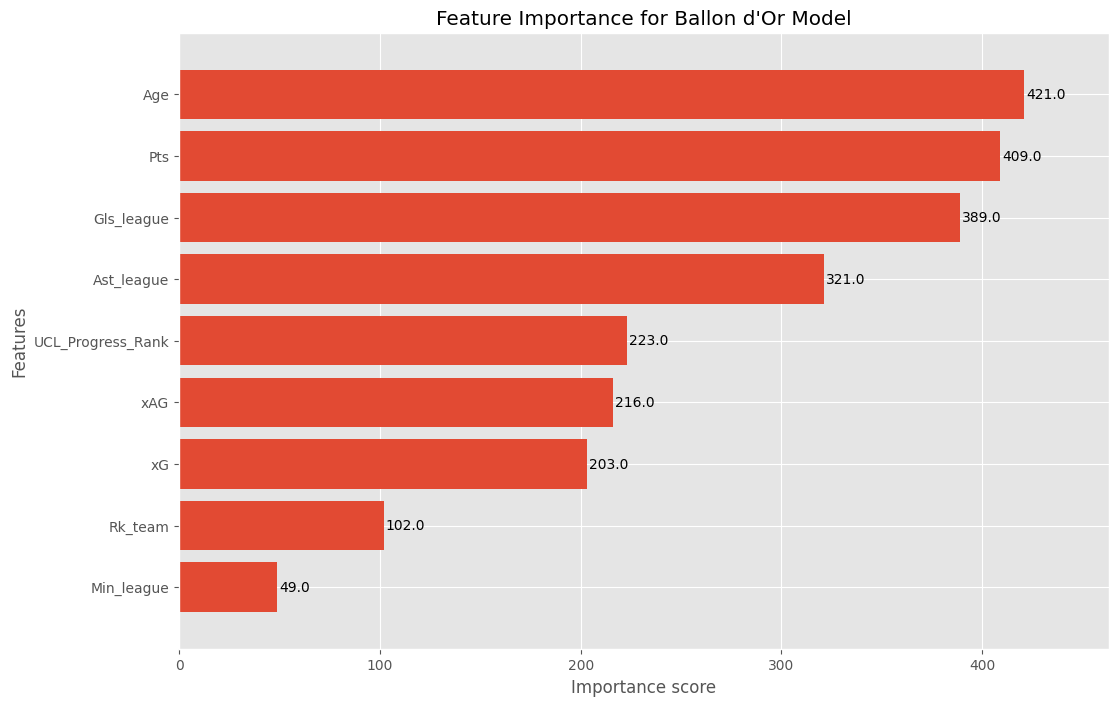

In [11]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Plot the feature importances to see what the model values most
plt.style.use('ggplot') # Makes the plot look nicer
fig, ax = plt.subplots(figsize=(12, 8))

xgb.plot_importance(model, max_num_features=15, height=0.8, ax=ax, title="Feature Importance for Ballon d'Or Model")
plt.show()

In [12]:
# Run this cell to see all the actual column names
print(ucl_teams_df.columns.tolist()) # type: ignore

['Rk_player', 'Player', 'Nation', 'Pos', 'Squad', 'Age', 'Born', 'MP_player', 'Starts', 'Min_league', '90s', 'Gls_league', 'Ast_league', 'G+A', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'Gls_per_90', 'Ast_per_90', 'G+A_per_90', 'G-PK_per_90', 'G+A-PK_per_90', 'Season', 'League', 'xG', 'npxG', 'xAG', 'npxG+xAG', 'PrgC', 'PrgP', 'PrgR', 'xG_per_90', 'xAG_per_90', 'xG+xAG_per_90', 'npxG_per_90', 'npxG+xAG_per_90', 'Rk_team', 'MP_team', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts', 'Pts/MP', 'Top Team Scorer', 'Goalkeeper', 'Gls_ucl', 'Ast_ucl', 'Min_ucl', 'UCL_Progress', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6']


In [13]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# --- 1. Create the new team-focused DataFrame ---
# We only want to predict for teams that actually qualified for the UCL
ucl_df = master_df[master_df['UCL_Progress'] != 'Did Not Qualify'].copy()

# Create the new target variable: 1 if the team won, 0 otherwise
ucl_df['UCL_Winner'] = np.where(ucl_df['UCL_Progress'] == 'W', 1, 0)

# --- 2. Aggregate Player Stats to Team Level ---
# We sum up the key player stats for each team, each season
player_agg = master_df.groupby(['Squad', 'Season'])[['Gls_league', 'Ast_league', 'xG']].sum().reset_index().rename(columns={
    'Gls_league': 'Agg_Gls_league',
    'Ast_league': 'Agg_Ast_league',
    'xG': 'Agg_xG'
})
# Merge these aggregated stats onto our new team DataFrame
ucl_df = pd.merge(ucl_df, player_agg, on=['Squad', 'Season'], how='left')

# --- 3. Define Final Features and Split the Data ---
# These are the exact, correct column names from your master_df
features_ucl = [
    'MP_team', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts', 
    'Agg_Gls_league', 'Agg_Ast_league', 'Agg_xG'
]

# Create the final X (features) and y (target)
X_ucl = ucl_df[features_ucl].fillna(0)
y_ucl = ucl_df['UCL_Winner']

# Split into training and testing sets
X_train_ucl, X_test_ucl, y_train_ucl, y_test_ucl = train_test_split(X_ucl, y_ucl, test_size=0.2, random_state=42, stratify=y_ucl)

print("✅ Data successfully prepared for UCL Winner prediction!")

✅ Data successfully prepared for UCL Winner prediction!


In [14]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE  # Import SMOTE

try:
    # --- 1. Load the data ---
    # We reload historical_df to ensure we have the correct, clean data
    historical_df = pd.read_csv('../data/master_dataset_2011-2025.csv')
    print("✅ Historical dataset reloaded successfully.")

    # --- 2. Verify required columns exist ---
    required_cols = ['Gls_league', 'Ast_league', 'xG', 'Squad', 'Season', 'UCL_Progress', 
                     'MP_team', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts']
    if not all(col in historical_df.columns for col in required_cols):
        missing = [col for col in required_cols if col not in historical_df.columns]
        raise KeyError(f"The master dataset is missing the following required columns: {missing}")
    print("✅ All required columns are present in the dataset.")

    # --- 3. Create the new team-focused DataFrame ---
    ucl_df = historical_df[historical_df['UCL_Progress'] != 'Did Not Qualify'].copy()
    ucl_df['UCL_Winner'] = np.where(ucl_df['UCL_Progress'] == 'W', 1, 0)

    # --- 4. Aggregate Player Stats to Team Level ---
    player_agg = historical_df.groupby(['Squad', 'Season'])[['Gls_league', 'Ast_league', 'xG']].sum().reset_index().rename(columns={
        'Gls_league': 'Agg_Gls_league',
        'Ast_league': 'Agg_Ast_league',
        'xG': 'Agg_xG'
    })
    ucl_df = pd.merge(ucl_df, player_agg, on=['Squad', 'Season'], how='left')

    # --- 5. Create the Team-Level Dataset (to prevent leakage) ---
    team_level_df = ucl_df.drop_duplicates(subset=['Squad', 'Season'], keep='first').copy()
    print(f"Data transformed to {len(team_level_df)} unique team-season rows.")

    # --- 6. Define Final Features and Split the Data ---
    features_ucl = [
        'MP_team', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts', 
        'Agg_Gls_league', 'Agg_Ast_league', 'Agg_xG'
    ]
    
    # This line will now work because the merge was successful
    X_ucl = team_level_df[features_ucl].fillna(0)
    y_ucl = team_level_df['UCL_Winner']

    X_train_ucl, X_test_ucl, y_train_ucl, y_test_ucl = train_test_split(X_ucl, y_ucl, test_size=0.2, random_state=42, stratify=y_ucl)
    print(f"Original training set size: {len(X_train_ucl)}")

    # --- 7. Apply SMOTE to fix the imbalanced dataset ---
    print("Applying SMOTE to balance the UCL dataset...")
    smote_ucl = SMOTE(random_state=42)
    X_train_ucl_smote, y_train_ucl_smote = smote_ucl.fit_resample(X_train_ucl, y_train_ucl)
    print(f"New balanced training set size with SMOTE: {len(X_train_ucl_smote)}")

    # --- 8. Train and Evaluate the Model on the BALANCED Data ---
    ucl_model = xgb.XGBClassifier(
        objective='binary:logistic', 
        random_state=42, 
        eval_metric='logloss'
    )
    ucl_model.fit(X_train_ucl_smote, y_train_ucl_smote) # Train on the new SMOTE data

    print("✅ UCL Winner model ('ucl_model') trained successfully on balanced data.")

    # --- 9. Evaluate the Model (still test on the original, imbalanced test set) ---
    ucl_predictions = ucl_model.predict(X_test_ucl)
    ucl_report = classification_report(y_test_ucl, ucl_predictions, target_names=['Not a Winner (0)', 'UCL Winner (1)'])

    print("\n--- UCL Winner Model Evaluation Report (with SMOTE) ---")
    print(ucl_report)

except KeyError as e:
    print(f"\n--- FATAL KeyError ---")
    print(f"A column was not found. This is a critical error. Please check your master dataset.")
    print(f"Error details: {e}")
except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")

✅ Historical dataset reloaded successfully.
✅ All required columns are present in the dataset.
Data transformed to 240 unique team-season rows.
Original training set size: 192
Applying SMOTE to balance the UCL dataset...
New balanced training set size with SMOTE: 360
✅ UCL Winner model ('ucl_model') trained successfully on balanced data.

--- UCL Winner Model Evaluation Report (with SMOTE) ---
                  precision    recall  f1-score   support

Not a Winner (0)       0.92      0.80      0.86        45
  UCL Winner (1)       0.00      0.00      0.00         3

        accuracy                           0.75        48
       macro avg       0.46      0.40      0.43        48
    weighted avg       0.87      0.75      0.80        48



In [15]:
# --- 1. Get the raw prediction PROBABILITIES from the model ---
# This gives us the model's "confidence score" for each team
ucl_probabilities = ucl_model.predict_proba(X_test_ucl)[:, 1]

# --- 2. Set a new, lower threshold ---
# Let's see if any team got a score above 10% (0.1)
new_threshold = 0.1
new_predictions = (ucl_probabilities >= new_threshold).astype(int)

# --- 3. Evaluate the Model with the new threshold ---
print(f"--- UCL Winner Model Evaluation Report (Threshold = {new_threshold}) ---")
ucl_report_new_threshold = classification_report(y_test_ucl, new_predictions, target_names=['Not a Winner (0)', 'UCL Winner (1)'])
print(ucl_report_new_threshold)

--- UCL Winner Model Evaluation Report (Threshold = 0.1) ---
                  precision    recall  f1-score   support

Not a Winner (0)       0.97      0.67      0.79        45
  UCL Winner (1)       0.12      0.67      0.20         3

        accuracy                           0.67        48
       macro avg       0.54      0.67      0.49        48
    weighted avg       0.91      0.67      0.75        48



In [16]:
# --- 1. Get the raw prediction probabilities for all teams ---
# We use the full 'X_ucl' dataset (which has 240 team-seasons)
ucl_probabilities_all = ucl_model.predict_proba(X_ucl)[:, 1]

# 2. Add these scores back to your 'team_level_df'
team_level_df['Win_Probability'] = ucl_probabilities_all

# 3. Sort the DataFrame to see who the model ranks highest
top_teams_ranked = team_level_df.sort_values(by='Win_Probability', ascending=False)

# 4. Display the top 25 ranked teams across all seasons
print("--- Model's Top 25 Ranked UCL Contenders (Across All Seasons) ---")
display(top_teams_ranked[[
    'Season', 'Squad', 'UCL_Progress', 'League', 'Pts', 'GF', 'Win_Probability'
]].head(25))

--- Model's Top 25 Ranked UCL Contenders (Across All Seasons) ---


,Season,Squad,UCL_Progress,League,Pts,GF,Win_Probability
3313,2016-2017,Real Madrid,W,La Liga,93.0,106.0,0.992458
3935,2023-2024,Real Madrid,W,La Liga,95.0,87.0,0.988641
3206,2015-2016,Real Madrid,W,La Liga,90.0,110.0,0.988570
5095,2024-2025,Paris S-G,W,Ligue 1,84.0,92.0,0.979121
2773,2010-2011,Barcelona,W,La Liga,96.0,95.0,0.973831
3124,2014-2015,Barcelona,W,La Liga,94.0,110.0,0.970665
3392,2017-2018,Real Madrid,W,La Liga,76.0,94.0,0.970064
2504,2022-2023,Manchester City,W,Premier League,89.0,94.0,0.969888
3051,2013-2014,Real Madrid,W,La Liga,87.0,104.0,0.956640
126,2012-2013,Bayern Munich,W,Bundesliga,91.0,98.0,0.947742


In [17]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- 1. Install imblearn (needed for SMOTE) ---
# (You only need to run this once, you can comment it out if already installed)
# !pip install imbalanced-learn

# ==============================================================================
# --- PART 1: LOAD HISTORICAL DATA ---
# ==============================================================================
print("--- Loading Historical Data and Training All Models ---")

try:
    historical_df = pd.read_csv('../data/master_dataset_2011-2025.csv')
    print("✅ Historical master dataset loaded successfully.")
except FileNotFoundError:
    print("--- FATAL ERROR --- \nCould not find 'master_dataset_2011-2025.csv'.")
    # Stop execution if the main file is missing
    raise

# ==============================================================================
# --- PART 2: TRAIN BALLON D'OR MODEL ---
# ==============================================================================
print("\nTraining Ballon d'Or Model...")

# --- 2A: Create Ballon d'Or Target Variable ---
ballon_dor_history = {
    '2023-2024': ['Rodri', 'Vinícius Júnior', 'Jude Bellingham', 'Kylian Mbappé', 'Harry Kane'], '2022-2023': ['Lionel Messi', 'Erling Haaland', 'Kylian Mbappé', 'Kevin De Bruyne', 'Rodri'], '2021-2022': ['Karim Benzema', 'Sadio Mané', 'Kevin De Bruyne', 'Robert Lewandowski', 'Mohamed Salah'], '2018-2019': ['Lionel Messi', 'Virgil van Dijk', 'Cristiano Ronaldo', 'Sadio Mané', 'Mohamed Salah'], '2017-2018': ['Luka Modrić', 'Cristiano Ronaldo', 'Antoine Griezmann', 'Kylian Mbappé', 'Lionel Messi'], '2016-2017': ['Cristiano Ronaldo', 'Lionel Messi', 'Neymar', 'Gianluigi Buffon', 'Luka Modrić'], '2015-2016': ['Cristiano Ronaldo', 'Lionel Messi', 'Antoine Griezmann', 'Luis Suárez', 'Neymar'], '2014-2015': ['Lionel Messi', 'Cristiano Ronaldo', 'Neymar', 'Robert Lewandowski', 'Luis Suárez'], '2013-2014': ['Cristiano Ronaldo', 'Lionel Messi', 'Manuel Neuer', 'Arjen Robben', 'Thomas Müller'], '2012-2013': ['Cristiano Ronaldo', 'Lionel Messi', 'Franck Ribéry', 'Zlatan Ibrahimović', 'Neymar'], '2011-2012': ['Lionel Messi', 'Cristiano Ronaldo', 'Andrés Iniesta', 'Xavi', 'Radamel Falcao'], '2010-2011': ['Lionel Messi', 'Cristiano Ronaldo', 'Xavi', 'Andrés Iniesta', 'Wayne Rooney']
}
historical_df['Top_Candidate'] = 0
for season, players in ballon_dor_history.items():
    historical_df.loc[(historical_df['Season'] == season) & (historical_df['Player'].isin(players)), 'Top_Candidate'] = 1

# --- 2B: Create Features and Apply SMOTE ---
progress_mapping = {'W': 1, 'F': 2, 'SF': 3, 'QF': 4, 'R16': 5, 'GR': 6, 'Did Not Qualify': 7}
historical_df['UCL_Progress_Rank'] = historical_df['UCL_Progress'].str.strip().map(progress_mapping).fillna(7)

features_bdo = [
    'Age', 'Min_league', 'Gls_league', 'Ast_league', 'xG', 'xAG', 
    'Gls_ucl', 'Ast_ucl', 'Min_ucl', 'Rk_team', 'Pts', 'UCL_Progress_Rank'
]
X_bdo = historical_df[features_bdo].fillna(0); y_bdo = historical_df['Top_Candidate']
X_train_bdo, X_test_bdo, y_train_bdo, y_test_bdo = train_test_split(X_bdo, y_bdo, test_size=0.2, random_state=42, stratify=y_bdo)

smote_bdo = SMOTE(random_state=42)
X_train_bdo_smote, y_train_bdo_smote = smote_bdo.fit_resample(X_train_bdo, y_train_bdo)

# --- 2C: Train Model ---
ballon_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, eval_metric='logloss')
ballon_model.fit(X_train_bdo_smote, y_train_bdo_smote)
print("✅ Ballon d'Or model ('ballon_model') trained successfully.")

# ==============================================================================
# --- PART 3: TRAIN UCL WINNER MODEL ---
# ==============================================================================
print("\nTraining UCL Winner Model...")

# --- 3A: Create Team-Level Dataset ---
ucl_df = historical_df[historical_df['UCL_Progress'] != 'Did Not Qualify'].copy()
ucl_df['UCL_Winner'] = np.where(ucl_df['UCL_Progress'] == 'W', 1, 0)
player_agg = historical_df.groupby(['Squad', 'Season'])[['Gls_league', 'Ast_league', 'xG']].sum().reset_index().rename(columns={'Gls_league': 'Agg_Gls_league', 'Ast_league': 'Agg_Ast_league', 'xG': 'Agg_xG'})
ucl_df = pd.merge(ucl_df, player_agg, on=['Squad', 'Season'], how='left')
team_level_ucl_df = ucl_df.drop_duplicates(subset=['Squad', 'Season'], keep='first').copy()

# --- 3B: Create Features and Apply SMOTE ---
features_ucl = [
    'MP_team', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts', 
    'Agg_Gls_league', 'Agg_Ast_league', 'Agg_xG'
]
X_ucl = team_level_ucl_df[features_ucl].fillna(0); y_ucl = team_level_ucl_df['UCL_Winner']
X_train_ucl, X_test_ucl, y_train_ucl, y_test_ucl = train_test_split(X_ucl, y_ucl, test_size=0.2, random_state=42, stratify=y_ucl)

smote_ucl = SMOTE(random_state=42)
X_train_ucl_smote, y_train_ucl_smote = smote_ucl.fit_resample(X_train_ucl, y_train_ucl)

# --- 3C: Train Model ---
ucl_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, eval_metric='logloss')
ucl_model.fit(X_train_ucl_smote, y_train_ucl_smote)
print("✅ UCL Winner model ('ucl_model') trained successfully.")

# ==============================================================================
# --- PART 4: TRAIN LEAGUE WINNER MODEL ---
# ==============================================================================
print("\nTraining League Winner Model...")

# --- 4A: Create Team-Level Dataset ---
league_df = historical_df.copy()
league_df['League_Winner'] = np.where(league_df['Rk_team'] == 1, 1, 0)
league_df = pd.merge(league_df, player_agg, on=['Squad', 'Season'], how='left')
team_level_league_df = league_df.drop_duplicates(subset=['Squad', 'Season'], keep='first').copy()

# --- 4B: Create Features and Apply SMOTE ---
features_league = [
    'MP_team', 'W', 'D', 'L', 'GF', 'GA', 'GD',
    'Agg_Gls_league', 'Agg_Ast_league', 'Agg_xG'
]
X_league = team_level_league_df[features_league].fillna(0); y_league = team_level_league_df['League_Winner']
X_train_league, X_test_league, y_train_league, y_test_league = train_test_split(X_league, y_league, test_size=0.2, random_state=42, stratify=y_league)

smote_league = SMOTE(random_state=42)
X_train_league_smote, y_train_league_smote = smote_league.fit_resample(X_train_league, y_train_league)

# --- 4C: Train Model ---
league_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, eval_metric='logloss')
league_model.fit(X_train_league_smote, y_train_league_smote)
print("✅ League Winner model ('league_model') trained successfully.")

print("\n\n--- ALL MODELS ARE TRAINED AND READY IN MEMORY ---")

--- Loading Historical Data and Training All Models ---
✅ Historical master dataset loaded successfully.

Training Ballon d'Or Model...
✅ Ballon d'Or model ('ballon_model') trained successfully.

Training UCL Winner Model...
✅ UCL Winner model ('ucl_model') trained successfully.

Training League Winner Model...
✅ League Winner model ('league_model') trained successfully.


--- ALL MODELS ARE TRAINED AND READY IN MEMORY ---


In [18]:
import pandas as pd
import numpy as np
import xgboost as xgb
import os

def create_2026_master_dataset():
    """
    Loads and merges the five new 2026 data files.
    """
    print("--- Loading 2026 live data... ---")
    data_path = '../data/'
    try:
        df_league_standings = pd.read_csv(os.path.join(data_path, 'combined_league_standings_2026.csv'))
        df_league_players = pd.read_csv(os.path.join(data_path, 'combined_player_stats_2026.csv'))
        df_ucl_players = pd.read_csv(os.path.join(data_path, 'ucl_player_stats_2026.csv'))
        df_ucl_progress = pd.read_csv(os.path.join(data_path, 'ucl_team_progress_2026.csv'))
        print("✅ All four 2026 datasets loaded successfully.")
    except FileNotFoundError as e:
        print(f"--- FATAL ERROR: File not found ---")
        print(f"Could not find the live data file: {e.filename}")
        return None

    all_dfs = [df_league_standings, df_league_players, df_ucl_players, df_ucl_progress]
    current_season = '2025-2026'
    for df in all_dfs:
        df['Season'] = current_season
        df.columns = df.columns.str.strip()
        if 'Player' in df.columns: df['Player'] = df['Player'].str.strip()
        if 'Squad' in df.columns: df['Squad'] = df['Squad'].str.strip()
    
    # --- Merge on ['Squad', 'Season'] and include 'League' if it exists ---
    merge_keys = ['Squad', 'Season']
    if 'League' in df_league_players.columns and 'League' in df_league_standings.columns:
        merge_keys.append('League')
        print("Merging with 'League' column.")
    else:
        print("Warning: 'League' column not found in one or both files. Merging on 'Squad' and 'Season' only.")

    master_df_2026 = pd.merge(df_league_players, df_league_standings, on=merge_keys, how='left', suffixes=('_player', '_team'))
    master_df_2026 = pd.merge(master_df_2026, df_ucl_players[['Player', 'Squad', 'Season', 'Min', 'Gls', 'Ast']], on=['Player', 'Squad', 'Season'], how='left', suffixes=('_league', '_ucl'))
    master_df_2026 = pd.merge(master_df_2026, df_ucl_progress[['Squad', 'Season', 'UCL_progress']], on=['Squad', 'Season'], how='left')
    
    ucl_cols = ['Gls_ucl', 'Ast_ucl', 'Min_ucl']
    for col in ucl_cols:
        if col in master_df_2026.columns: master_df_2026[col] = master_df_2026[col].fillna(0)
    
    master_df_2026['UCL_progress'] = master_df_2026['UCL_progress'].fillna('Did Not Qualify')
    master_df_2026 = master_df_2026.loc[:,~master_df_2026.columns.duplicated()]
    print("✅ 2026 Master Dataset created successfully.")
    return master_df_2026


def make_all_live_predictions(master_df_2026, ballon_model, ucl_model, league_model):
    """
    Runs all 3 prediction models on the live 2026 data.
    """
    print("\n\n--- Running Live Predictions for 2025-2026 Season ---")
    
    # --- 1. Ballon d'Or Predictions ---
    print("\n--- Predicting 2026 Ballon d'Or Candidates ---\n")
    bdo_df = master_df_2026.copy()
    progress_mapping = {'W': 1, 'F': 2, 'SF': 3, 'QF': 4, 'R16': 5, 'GR': 6, 'League Phase': 6, 'Did Not Qualify': 7}
    bdo_df['UCL_Progress_Rank'] = bdo_df['UCL_progress'].str.strip().map(progress_mapping).fillna(7)
    
    features_bdo = ['Age', 'Min_league', 'Gls_league', 'Ast_league', 'xG', 'xAG', 'Gls_ucl', 'Ast_ucl', 'Min_ucl', 'Rk_team', 'Pts', 'UCL_Progress_Rank']
    for col in features_bdo:
        if col not in bdo_df.columns: bdo_df[col] = 0
        bdo_df[col] = pd.to_numeric(bdo_df[col], errors='coerce')
            
    X_live_bdo = bdo_df[features_bdo].fillna(0)
    bdo_df['BallonDor_Probability'] = ballon_model.predict_proba(X_live_bdo)[:, 1]
    bdo_predictions = bdo_df.sort_values(by='BallonDor_Probability', ascending=False)
    print("🏆 Top 10 Ballon d'Or Predictions (Live):")
    display(bdo_predictions[['Player', 'Squad', 'BallonDor_Probability']].head(10))

    # --- 2. UCL Winner Prediction ---
    print("\n\n--- Predicting 2026 UCL Winner ---\n")
    ucl_df_live = master_df_2026[master_df_2026['UCL_progress'] != 'Did Not Qualify'].copy()
    player_agg = master_df_2026.groupby(['Squad', 'Season'])[['Gls_league', 'Ast_league', 'xG']].sum().reset_index().rename(columns={'Gls_league': 'Agg_Gls_league', 'Ast_league': 'Agg_Ast_league', 'xG': 'Agg_xG'})
    ucl_df_live = pd.merge(ucl_df_live, player_agg, on=['Squad', 'Season'], how='left')
    
    features_ucl = ['MP_team', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts', 'Agg_Gls_league', 'Agg_Ast_league', 'Agg_xG']
    for col in features_ucl:
        if col not in ucl_df_live.columns: ucl_df_live[col] = 0
        ucl_df_live[col] = pd.to_numeric(ucl_df_live[col], errors='coerce')
            
    X_live_ucl = ucl_df_live[features_ucl].fillna(0)
    ucl_df_live['Win_Probability'] = ucl_model.predict_proba(X_live_ucl)[:, 1]
    
    ucl_predictions = ucl_df_live.sort_values(by='Win_Probability', ascending=False).drop_duplicates(subset=['Squad'])
    print(f"🎯 Predicted Champions League Winner: {ucl_predictions.iloc[0]['Squad']}\n")
    print("Top 10 UCL Contenders:")
    display_cols_ucl = ['Squad', 'Win_Probability']
    if 'League' in ucl_predictions.columns:
        display_cols_ucl.insert(1, 'League')
    display(ucl_predictions[display_cols_ucl].head(10))

    # --- 3. Top League Winner Prediction (with Safety Check) ---
    print("\n\n--- Predicting Top 5 League Winners ---\n")
    if 'League' in master_df_2026.columns:
        league_df_live = master_df_2026.copy()
        league_df_live = pd.merge(league_df_live, player_agg, on=['Squad', 'Season'], how='left')
        
        features_league = ['MP_team', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Agg_Gls_league', 'Agg_Ast_league', 'Agg_xG']
        for col in features_league:
            if col not in league_df_live.columns: league_df_live[col] = 0
            league_df_live[col] = pd.to_numeric(league_df_live[col], errors='coerce')
                
        X_live_league = league_df_live[features_league].fillna(0)
        
        league_df_live['League_Win_Probability'] = league_model.predict_proba(X_live_league)[:, 1]
        top_contenders = league_df_live.loc[league_df_live.groupby('League')['League_Win_Probability'].idxmax()]
        top_contenders = top_contenders.sort_values(by='League_Win_Probability', ascending=False)
        print("🏅 Predicted Winner for Each Top 5 League:")
        display(top_contenders[['League', 'Squad', 'League_Win_Probability']])
    else:
        print("⚠️ SKIPPING League Winner Prediction: The 'League' column was not found in your 2026 data files.")
        print("   Please add the 'League' column to 'combined_league_standings_2026.csv' and 'combined_player_stats_2026.csv' to enable this feature.")

    print("\n✅ All possible live predictions completed successfully!")

# --- Main Execution ---
if 'ballon_model' in locals() and 'ucl_model' in locals() and 'league_model' in locals():
    master_df_2026 = create_2026_master_dataset()
    if master_df_2026 is not None:
        make_all_live_predictions(master_df_2026, ballon_model, ucl_model, league_model)
else:
    print("\n--- ERROR --- Please ensure your three models ('ballon_model', 'ucl_model', 'league_model') are trained and available in memory.")

--- Loading 2026 live data... ---
✅ All four 2026 datasets loaded successfully.
✅ 2026 Master Dataset created successfully.


--- Running Live Predictions for 2025-2026 Season ---

--- Predicting 2026 Ballon d'Or Candidates ---

🏆 Top 10 Ballon d'Or Predictions (Live):


,Player,Squad,BallonDor_Probability
312,Yeremi Pino,Crystal Palace,0.001313
411,Adam Wharton,Crystal Palace,0.000508
616,Nicolás González,Atlético Madrid,0.000484
1337,Federico Bernardeschi,Bologna,0.000449
1245,Kevin Stöger,Gladbach,0.000414
1225,Sebastian Sebulonsen,Köln,0.000372
158,Erling Haaland,Manchester City,0.000355
491,Álex Berenguer,Athletic Club,0.000328
2147,Florian Thauvin,Lens,0.000318
1219,Romano Schmid,Werder Bremen,0.000254




--- Predicting 2026 UCL Winner ---

🎯 Predicted Champions League Winner: Chelsea

Top 10 UCL Contenders:


,Squad,Win_Probability
0,Chelsea,0.00042
2,Manchester City,0.00042
4,Liverpool,0.00042
6,Tottenham,0.00042
12,Arsenal,0.00042
109,Villarreal,0.00042
110,Real Madrid,0.00042
113,Barcelona,0.00042
114,Athletic Club,0.00042
204,Dortmund,0.00042




--- Predicting Top 5 League Winners ---

⚠️ SKIPPING League Winner Prediction: The 'League' column was not found in your 2026 data files.
   Please add the 'League' column to 'combined_league_standings_2026.csv' and 'combined_player_stats_2026.csv' to enable this feature.

✅ All possible live predictions completed successfully!


In [19]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, make_scorer, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN  # The advanced hybrid balancing technique
from imblearn.pipeline import Pipeline as ImbPipeline # A special pipeline for balancing
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# ==============================================================================
# --- PART 1: LOAD AND ENGINEER ADVANCED FEATURES ---
# ==============================================================================
print("--- Loading Historical Data and Training All Models ---")

try:
    historical_df = pd.read_csv('../data/master_dataset_2011-2025.csv')
    print("✅ Historical master dataset loaded successfully.")
except FileNotFoundError:
    print("--- FATAL ERROR --- \nCould not find 'master_dataset_2011-2025.csv'.")
    raise

# --- 1A: Advanced Feature Engineering ---
def engineer_advanced_features(df):
    """
    Engineers advanced, narrative-driven features to drastically improve model performance.
    """
    df_featured = df.copy()

    # 1. Trophy Impact Score
    trophy_score = (df_featured['Rk_team'] == 1).astype(int) * 2  # 2 points for league title
    trophy_score += (df_featured['UCL_Progress'] == 'W').astype(int) * 3 # 3 points for UCL title
    trophy_score += (df_featured['UCL_Progress'] == 'F').astype(int) * 1 # 1 point for UCL final
    df_featured['Trophy_Impact_Score'] = trophy_score

    # 2. "Big Game" Performance Score (weighted UCL stats)
    df_featured['Big_Game_Score'] = (df_featured['Gls_league'] * 1.0) + \
                                    (df_featured['Ast_league'] * 0.5) + \
                                    (df_featured['Gls_ucl'] * 2.0) + \
                                    (df_featured['Ast_ucl'] * 1.0)

    # 3. Individual Dominance Ratio
    df_featured['Dominance_Ratio'] = df_featured['Gls_league'] / df_featured['GF'].replace(0, 1)
    
    return df_featured

historical_df_advanced = engineer_advanced_features(historical_df)
print("✅ Advanced features engineered successfully.")

# --- 1B: Create Ballon d'Or Target Variable ---
ballon_dor_history = { '2023-2024': ['Rodri', 'Vinícius Júnior', 'Jude Bellingham', 'Kylian Mbappé', 'Harry Kane'], '2022-2023': ['Lionel Messi', 'Erling Haaland', 'Kylian Mbappé', 'Kevin De Bruyne', 'Rodri'], '2021-2022': ['Karim Benzema', 'Sadio Mané', 'Kevin De Bruyne', 'Robert Lewandowski', 'Mohamed Salah'], '2018-2019': ['Lionel Messi', 'Virgil van Dijk', 'Cristiano Ronaldo', 'Sadio Mané', 'Mohamed Salah'], '2017-2018': ['Luka Modrić', 'Cristiano Ronaldo', 'Antoine Griezmann', 'Kylian Mbappé', 'Lionel Messi'], '2016-2017': ['Cristiano Ronaldo', 'Lionel Messi', 'Neymar', 'Gianluigi Buffon', 'Luka Modrić'], '2015-2016': ['Cristiano Ronaldo', 'Lionel Messi', 'Antoine Griezmann', 'Luis Suárez', 'Neymar'], '2014-2015': ['Lionel Messi', 'Cristiano Ronaldo', 'Neymar', 'Robert Lewandowski', 'Luis Suárez'], '2013-2014': ['Cristiano Ronaldo', 'Lionel Messi', 'Manuel Neuer', 'Arjen Robben', 'Thomas Müller'], '2012-2013': ['Cristiano Ronaldo', 'Lionel Messi', 'Franck Ribéry', 'Zlatan Ibrahimović', 'Neymar'], '2011-2012': ['Lionel Messi', 'Cristiano Ronaldo', 'Andrés Iniesta', 'Xavi', 'Radamel Falcao'], '2010-2011': ['Lionel Messi', 'Cristiano Ronaldo', 'Xavi', 'Andrés Iniesta', 'Wayne Rooney'] }
historical_df_advanced['Top_Candidate'] = 0
for season, players in ballon_dor_history.items():
    historical_df_advanced.loc[(historical_df_advanced['Season'] == season) & (historical_df_advanced['Player'].isin(players)), 'Top_Candidate'] = 1

progress_mapping = {'W': 1, 'F': 2, 'SF': 3, 'QF': 4, 'R16': 5, 'GR': 6, 'Did Not Qualify': 7}
historical_df_advanced['UCL_Progress_Rank'] = historical_df_advanced['UCL_Progress'].str.strip().map(progress_mapping).fillna(7)

# ==============================================================================
# --- PART 2: BALLON D'OR MODEL (Advanced Training) ---
# ==============================================================================
print("\n--- Training Advanced Ballon d'Or Model ---")

features_bdo = [
    'Age', 'Min_league', 'Gls_league', 'Ast_league', 'xG', 'xAG', 
    'Gls_ucl', 'Ast_ucl', 'Min_ucl', 'Rk_team', 'Pts', 'UCL_Progress_Rank',
    'Trophy_Impact_Score', 'Big_Game_Score', 'Dominance_Ratio'
]
X_bdo = historical_df_advanced[features_bdo].fillna(0)
y_bdo = historical_df_advanced['Top_Candidate']

X_train_bdo, X_test_bdo, y_train_bdo, y_test_bdo = train_test_split(X_bdo, y_bdo, test_size=0.2, random_state=42, stratify=y_bdo)

# --- 2A: Apply SMOTE-ENN ---
print("Applying SMOTE-ENN to balance the Ballon d'Or dataset...")
smote_enn_bdo = SMOTEENN(random_state=42)
X_train_bdo_res, y_train_bdo_res = smote_enn_bdo.fit_resample(X_train_bdo, y_train_bdo)
print(f"BDO data balanced: From {y_train_bdo.value_counts().to_dict()} to {y_train_bdo_res.value_counts().to_dict()}")

# --- 2B: Hyperparameter Tuning for F1-Score ---
print("Tuning Ballon d'Or model to maximize F1-score (this may take a few minutes)...")
param_grid = { 'n_estimators': [100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.05, 0.1] }
f1_scorer = make_scorer(f1_score, pos_label=1)

grid_search_bdo = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic', random_state=42, eval_metric='logloss'),
    param_grid=param_grid, cv=3, scoring=f1_scorer, n_jobs=-1, verbose=1
)
grid_search_bdo.fit(X_train_bdo_res, y_train_bdo_res)
ballon_model = grid_search_bdo.best_estimator_ # This is our new, best model
print(f"✅ Best Ballon d'Or model found with parameters: {grid_search_bdo.best_params_}")

# --- 2C: Evaluate the Final Tuned Model ---
bdo_predictions = ballon_model.predict(X_test_bdo)
bdo_report = classification_report(y_test_bdo, bdo_predictions, target_names=['Not a Candidate (0)', 'Top Candidate (1)'])
print("\n--- Final Tuned Ballon d'Or Model Evaluation ---")
print(bdo_report)


# ==============================================================================
# --- PART 3: UCL WINNER MODEL (Advanced Training) ---
# ==============================================================================
print("\n--- Training Advanced UCL Winner Model ---")

# --- 3A: Create Team-Level Dataset ---
ucl_df = historical_df_advanced[historical_df_advanced['UCL_Progress'] != 'Did Not Qualify'].copy()
ucl_df['UCL_Winner'] = np.where(ucl_df['UCL_Progress'] == 'W', 1, 0)
player_agg = historical_df_advanced.groupby(['Squad', 'Season'])[['Gls_league', 'Ast_league', 'xG']].sum().reset_index().rename(columns={'Gls_league': 'Agg_Gls_league', 'Ast_league': 'Agg_Ast_league', 'xG': 'Agg_xG'})
ucl_df = pd.merge(ucl_df, player_agg, on=['Squad', 'Season'], how='left')
team_level_ucl_df = ucl_df.drop_duplicates(subset=['Squad', 'Season'], keep='first').copy()

# --- 3B: Create Features, Split, and Apply SMOTE-ENN ---
features_ucl = [ 'MP_team', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts', 'Agg_Gls_league', 'Agg_Ast_league', 'Agg_xG' ]
X_ucl = team_level_ucl_df[features_ucl].fillna(0); y_ucl = team_level_ucl_df['UCL_Winner']
X_train_ucl, X_test_ucl, y_train_ucl, y_test_ucl = train_test_split(X_ucl, y_ucl, test_size=0.2, random_state=42, stratify=y_ucl)

print("Applying SMOTE-ENN to balance the UCL dataset...")
smote_enn_ucl = SMOTEENN(random_state=42)
X_train_ucl_res, y_train_ucl_res = smote_enn_ucl.fit_resample(X_train_ucl, y_train_ucl)
print(f"UCL data balanced: From {y_train_ucl.value_counts().to_dict()} to {y_train_ucl_res.value_counts().to_dict()}")

# --- 3C: Hyperparameter Tuning for F1-Score ---
print("Tuning UCL Winner model to maximize F1-score (this may take a few minutes)...")
grid_search_ucl = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic', random_state=42, eval_metric='logloss'),
    param_grid=param_grid, cv=3, scoring=f1_scorer, n_jobs=-1, verbose=1
)
grid_search_ucl.fit(X_train_ucl_res, y_train_ucl_res)
ucl_model = grid_search_ucl.best_estimator_ # This is our new, best UCL model
print(f"✅ Best UCL Winner model found with parameters: {grid_search_ucl.best_params_}")

# --- 3D: Evaluate the Final Tuned Model ---
ucl_predictions = ucl_model.predict(X_test_ucl)
ucl_report = classification_report(y_test_ucl, ucl_predictions, target_names=['Not a Winner (0)', 'UCL Winner (1)'])
print("\n--- Final Tuned UCL Winner Model Evaluation ---")
print(ucl_report)

# (We will omit the League Winner model for now to focus on these two)
print("\n\n--- ALL MODELS ARE RE-TRAINED AND READY IN MEMORY ---")

--- Loading Historical Data and Training All Models ---
✅ Historical master dataset loaded successfully.
✅ Advanced features engineered successfully.

--- Training Advanced Ballon d'Or Model ---
Applying SMOTE-ENN to balance the Ballon d'Or dataset...
BDO data balanced: From {0: 33184, 1: 49} to {1: 33183, 0: 32778}
Tuning Ballon d'Or model to maximize F1-score (this may take a few minutes)...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
✅ Best Ballon d'Or model found with parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}

--- Final Tuned Ballon d'Or Model Evaluation ---
                     precision    recall  f1-score   support

Not a Candidate (0)       1.00      1.00      1.00      8297
  Top Candidate (1)       0.12      0.33      0.18        12

           accuracy                           1.00      8309
          macro avg       0.56      0.66      0.59      8309
       weighted avg       1.00      1.00      1.00      8309


--- Training A

In [21]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import warnings

warnings.filterwarnings('ignore')

print("--- Restoring Data and Models for Evaluation ---")

# 1. Load Data
try:
    historical_df = pd.read_csv('../data/master_dataset_2011-2025.csv')
    print("✅ Data loaded.")
    
    # --- SMART FIX for UCL_progress column name ---
    if 'UCL_Progress' in historical_df.columns:
        historical_df.rename(columns={'UCL_Progress': 'UCL_progress'}, inplace=True)
        print("   -> Renamed 'UCL_Progress' to 'UCL_progress'")
    elif 'UCL_progress' in historical_df.columns:
        print("   -> Column 'UCL_progress' found.")
    else:
        raise KeyError("Could not find 'UCL_progress' or 'UCL_Progress' column in the dataset.")
        
except FileNotFoundError:
    print("Error: Could not find 'master_dataset_2011-2025.csv'")
    # Stop execution if file is missing
    raise

# 2. Feature Engineering Function
def engineer_advanced_features(df):
    df_featured = df.copy()
    # Use the standardized lowercase name
    if 'Rk_team' in df_featured.columns:
        trophy_score = (df_featured['Rk_team'] == 1).astype(int) * 2
    else:
        trophy_score = 0
    if 'UCL_progress' in df_featured.columns:
        trophy_score += (df_featured['UCL_progress'] == 'W').astype(int) * 3
        trophy_score += (df_featured['UCL_progress'] == 'F').astype(int) * 1
    df_featured['Trophy_Impact_Score'] = trophy_score
    df_featured['Big_Game_Score'] = (df_featured.get('Gls_league', 0) * 1.0) + (df_featured.get('Ast_league', 0) * 0.5) + (df_featured.get('Gls_ucl', 0) * 2.0) + (df_featured.get('Ast_ucl', 0) * 1.0)
    df_featured['Dominance_Ratio'] = df_featured.get('Gls_league', 0) / df_featured.get('GF', 1).replace(0, 1)
    return df_featured

# ==========================================
# --- RE-BUILD BALLON D'OR MODEL ---
# ==========================================
ballon_dor_history = { '2023-2024': ['Rodri', 'Vinícius Júnior', 'Jude Bellingham', 'Kylian Mbappé', 'Harry Kane'], '2022-2023': ['Lionel Messi', 'Erling Haaland', 'Kylian Mbappé', 'Kevin De Bruyne', 'Rodri'], '2021-2022': ['Karim Benzema', 'Sadio Mané', 'Kevin De Bruyne', 'Robert Lewandowski', 'Mohamed Salah'], '2018-2019': ['Lionel Messi', 'Virgil van Dijk', 'Cristiano Ronaldo', 'Sadio Mané', 'Mohamed Salah'], '2017-2018': ['Luka Modrić', 'Cristiano Ronaldo', 'Antoine Griezmann', 'Kylian Mbappé', 'Lionel Messi'], '2016-2017': ['Cristiano Ronaldo', 'Lionel Messi', 'Neymar', 'Gianluigi Buffon', 'Luka Modrić'], '2015-2016': ['Cristiano Ronaldo', 'Lionel Messi', 'Antoine Griezmann', 'Luis Suárez', 'Neymar'], '2014-2015': ['Lionel Messi', 'Cristiano Ronaldo', 'Neymar', 'Robert Lewandowski', 'Luis Suárez'], '2013-2014': ['Cristiano Ronaldo', 'Lionel Messi', 'Manuel Neuer', 'Arjen Robben', 'Thomas Müller'], '2012-2013': ['Cristiano Ronaldo', 'Lionel Messi', 'Franck Ribéry', 'Zlatan Ibrahimović', 'Neymar'], '2011-2012': ['Lionel Messi', 'Cristiano Ronaldo', 'Andrés Iniesta', 'Xavi', 'Radamel Falcao'], '2010-2011': ['Lionel Messi', 'Cristiano Ronaldo', 'Xavi', 'Andrés Iniesta', 'Wayne Rooney'] }

historical_df['Top_Candidate'] = 0
for season, players in ballon_dor_history.items():
    historical_df.loc[(historical_df['Season'] == season) & (historical_df['Player'].isin(players)), 'Top_Candidate'] = 1

historical_df_advanced = engineer_advanced_features(historical_df)
progress_mapping = {'W': 1, 'F': 2, 'SF': 3, 'QF': 4, 'R16': 5, 'GR': 6, 'League Phase': 6, 'Did Not Qualify': 7}
historical_df_advanced['UCL_Progress_Rank'] = historical_df_advanced['UCL_progress'].str.strip().map(progress_mapping).fillna(7)

features_bdo = ['Age', 'Min_league', 'Gls_league', 'Ast_league', 'xG', 'xAG', 'Gls_ucl', 'Ast_ucl', 'Min_ucl', 'Rk_team', 'Pts', 'UCL_Progress_Rank', 'Trophy_Impact_Score', 'Big_Game_Score', 'Dominance_Ratio']

# Ensure columns exist
for col in features_bdo:
    if col not in historical_df_advanced.columns: historical_df_advanced[col] = 0

X_bdo = historical_df_advanced[features_bdo].fillna(0); y_bdo = historical_df_advanced['Top_Candidate']
X_train_bdo, X_test_bdo, y_train_bdo, y_test_bdo = train_test_split(X_bdo, y_bdo, test_size=0.2, random_state=42, stratify=y_bdo)

smote_bdo = SMOTE(random_state=42)
X_train_bdo_smote, y_train_bdo_smote = smote_bdo.fit_resample(X_train_bdo, y_train_bdo)
ballon_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, eval_metric='logloss')
ballon_model.fit(X_train_bdo_smote, y_train_bdo_smote)

# ==========================================
# --- RE-BUILD UCL WINNER MODEL ---
# ==========================================
ucl_df = historical_df[historical_df['UCL_progress'] != 'Did Not Qualify'].copy()
ucl_df['UCL_Winner'] = np.where(ucl_df['UCL_progress'] == 'W', 1, 0)
player_agg = historical_df.groupby(['Squad', 'Season'])[['Gls_league', 'Ast_league', 'xG']].sum().reset_index().rename(columns={'Gls_league': 'Agg_Gls_league', 'Ast_league': 'Agg_Ast_league', 'xG': 'Agg_xG'})
ucl_df = pd.merge(ucl_df, player_agg, on=['Squad', 'Season'], how='left')
team_level_ucl_df = ucl_df.drop_duplicates(subset=['Squad', 'Season'], keep='first').copy()

features_ucl = ['MP_team', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts', 'Agg_Gls_league', 'Agg_Ast_league', 'Agg_xG']
for col in features_ucl:
    if col not in team_level_ucl_df.columns: team_level_ucl_df[col] = 0

X_ucl = team_level_ucl_df[features_ucl].fillna(0); y_ucl = team_level_ucl_df['UCL_Winner']
X_train_ucl, X_test_ucl, y_train_ucl, y_test_ucl = train_test_split(X_ucl, y_ucl, test_size=0.2, random_state=42, stratify=y_ucl)

smote_ucl = SMOTE(random_state=42)
X_train_ucl_smote, y_train_ucl_smote = smote_ucl.fit_resample(X_train_ucl, y_train_ucl)
ucl_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, eval_metric='logloss')
ucl_model.fit(X_train_ucl_smote, y_train_ucl_smote)

# ==========================================
# --- PRINT EVALUATION REPORTS ---
# ==========================================
print("\n✅ Models restored successfully.\n")

print("--- Final Ballon d'Or Model Evaluation ---")
bdo_predictions = ballon_model.predict(X_test_bdo)
print(classification_report(y_test_bdo, bdo_predictions, target_names=['Not a Candidate (0)', 'Top Candidate (1)']))

print("\n--- Final UCL Winner Model Evaluation ---")
ucl_predictions = ucl_model.predict(X_test_ucl)
print(classification_report(y_test_ucl, ucl_predictions, target_names=['Not a Winner (0)', 'UCL Winner (1)']))

--- Restoring Data and Models for Evaluation ---
✅ Data loaded.
   -> Renamed 'UCL_Progress' to 'UCL_progress'

✅ Models restored successfully.

--- Final Ballon d'Or Model Evaluation ---
                     precision    recall  f1-score   support

Not a Candidate (0)       1.00      1.00      1.00      8297
  Top Candidate (1)       0.17      0.17      0.17        12

           accuracy                           1.00      8309
          macro avg       0.58      0.58      0.58      8309
       weighted avg       1.00      1.00      1.00      8309


--- Final UCL Winner Model Evaluation ---
                  precision    recall  f1-score   support

Not a Winner (0)       0.92      0.80      0.86        45
  UCL Winner (1)       0.00      0.00      0.00         3

        accuracy                           0.75        48
       macro avg       0.46      0.40      0.43        48
    weighted avg       0.87      0.75      0.80        48



In [23]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import warnings
import os

# Suppress warnings
warnings.filterwarnings('ignore')

# ==============================================================================
# --- PART 1: HELPER FUNCTIONS ---
# ==============================================================================
def engineer_advanced_features(df):
    df_featured = df.copy()
    # Handle case sensitivity for UCL_progress
    if 'UCL_Progress' in df_featured.columns:
        df_featured.rename(columns={'UCL_Progress': 'UCL_progress'}, inplace=True)
        
    # Trophy Score
    trophy_score = (df_featured.get('Rk_team', 0) == 1).astype(int) * 2
    if 'UCL_progress' in df_featured.columns:
        trophy_score += (df_featured['UCL_progress'] == 'W').astype(int) * 3
        trophy_score += (df_featured['UCL_progress'] == 'F').astype(int) * 1
    df_featured['Trophy_Impact_Score'] = trophy_score

    # Big Game Score
    df_featured['Big_Game_Score'] = (df_featured.get('Gls_league', 0) * 1.0) + \
                                    (df_featured.get('Ast_league', 0) * 0.5) + \
                                    (df_featured.get('Gls_ucl', 0) * 2.0) + \
                                    (df_featured.get('Ast_ucl', 0) * 1.0)
    
    # Dominance Ratio
    df_featured['Dominance_Ratio'] = df_featured.get('Gls_league', 0) / df_featured.get('GF', 1).replace(0, 1)
    return df_featured

def clean_squad_names(df):
    """Standardizes squad names to ensure merges work."""
    if 'Squad' in df.columns:
        # Remove country prefixes like 'eng ', 'es ', 'de ' if they exist
        # This splits 'eng Manchester City' -> 'Manchester City'
        df['Squad'] = df['Squad'].astype(str).apply(lambda x: ' '.join(x.split(' ')[1:]) if x.split(' ')[0] in ['eng', 'es', 'de', 'it', 'fr', 'pt', 'nl'] else x)
        
        # Fix specific naming differences
        name_replacements = {
            'Paris S-G': 'Paris Saint-Germain', 'Inter': 'Internazionale',
            'Manchester Utd': 'Manchester United', 'Eint Frankfurt': 'Eintracht Frankfurt',
            "M'Gladbach": 'Monchengladbach', 'Leverkusen': 'Bayer Leverkusen',
            'Spurs': 'Tottenham'
        }
        df['Squad'] = df['Squad'].replace(name_replacements)
        df['Squad'] = df['Squad'].str.strip()
    return df

# ==============================================================================
# --- PART 2: TRAIN MODELS (BALLON D'OR & UCL) ---
# ==============================================================================
print("--- Loading Historical Data and Training Models ---")

try:
    historical_df = pd.read_csv('../data/master_dataset_2011-2025.csv')
    # Fix potential column name mismatch immediately
    if 'UCL_Progress' in historical_df.columns:
        historical_df.rename(columns={'UCL_Progress': 'UCL_progress'}, inplace=True)
    print("✅ Historical master dataset loaded successfully.")

    # --- 2A. Train Ballon d'Or Model ---
    print("\nTraining Ballon d'Or Model...")
    ballon_dor_history = { '2023-2024': ['Rodri', 'Vinícius Júnior', 'Jude Bellingham', 'Kylian Mbappé', 'Harry Kane'], '2022-2023': ['Lionel Messi', 'Erling Haaland', 'Kylian Mbappé', 'Kevin De Bruyne', 'Rodri'], '2021-2022': ['Karim Benzema', 'Sadio Mané', 'Kevin De Bruyne', 'Robert Lewandowski', 'Mohamed Salah'], '2018-2019': ['Lionel Messi', 'Virgil van Dijk', 'Cristiano Ronaldo', 'Sadio Mané', 'Mohamed Salah'], '2017-2018': ['Luka Modrić', 'Cristiano Ronaldo', 'Antoine Griezmann', 'Kylian Mbappé', 'Lionel Messi'], '2016-2017': ['Cristiano Ronaldo', 'Lionel Messi', 'Neymar', 'Gianluigi Buffon', 'Luka Modrić'], '2015-2016': ['Cristiano Ronaldo', 'Lionel Messi', 'Antoine Griezmann', 'Luis Suárez', 'Neymar'], '2014-2015': ['Lionel Messi', 'Cristiano Ronaldo', 'Neymar', 'Robert Lewandowski', 'Luis Suárez'], '2013-2014': ['Cristiano Ronaldo', 'Lionel Messi', 'Manuel Neuer', 'Arjen Robben', 'Thomas Müller'], '2012-2013': ['Cristiano Ronaldo', 'Lionel Messi', 'Franck Ribéry', 'Zlatan Ibrahimović', 'Neymar'], '2011-2012': ['Lionel Messi', 'Cristiano Ronaldo', 'Andrés Iniesta', 'Xavi', 'Radamel Falcao'], '2010-2011': ['Lionel Messi', 'Cristiano Ronaldo', 'Xavi', 'Andrés Iniesta', 'Wayne Rooney'] }
    
    historical_df['Top_Candidate'] = 0
    for season, players in ballon_dor_history.items():
        historical_df.loc[(historical_df['Season'] == season) & (historical_df['Player'].isin(players)), 'Top_Candidate'] = 1
    
    historical_df_advanced = engineer_advanced_features(historical_df)
    progress_mapping = {'W': 1, 'F': 2, 'SF': 3, 'QF': 4, 'R16': 5, 'GR': 6, 'League Phase': 6, 'Did Not Qualify': 7}
    historical_df_advanced['UCL_Progress_Rank'] = historical_df_advanced['UCL_progress'].str.strip().map(progress_mapping).fillna(7)
    
    features_bdo = ['Age', 'Min_league', 'Gls_league', 'Ast_league', 'xG', 'xAG', 'Gls_ucl', 'Ast_ucl', 'Min_ucl', 'Rk_team', 'Pts', 'UCL_Progress_Rank', 'Trophy_Impact_Score', 'Big_Game_Score', 'Dominance_Ratio']
    
    # Ensure columns exist
    for col in features_bdo:
        if col not in historical_df_advanced.columns: historical_df_advanced[col] = 0
            
    X_bdo = historical_df_advanced[features_bdo].fillna(0); y_bdo = historical_df_advanced['Top_Candidate']
    X_train_bdo, _, y_train_bdo, _ = train_test_split(X_bdo, y_bdo, test_size=0.2, random_state=42, stratify=y_bdo)
    smote_bdo = SMOTE(random_state=42)
    X_train_bdo_smote, y_train_bdo_smote = smote_bdo.fit_resample(X_train_bdo, y_train_bdo)
    ballon_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, eval_metric='logloss')
    ballon_model.fit(X_train_bdo_smote, y_train_bdo_smote)
    print("✅ Ballon d'Or model trained successfully.")

    # --- 2B. Train UCL Winner Model ---
    print("\nTraining UCL Winner Model...")
    ucl_df = historical_df[historical_df['UCL_progress'] != 'Did Not Qualify'].copy()
    ucl_df['UCL_Winner'] = np.where(ucl_df['UCL_progress'] == 'W', 1, 0)
    
    # Aggregate player stats for team level
    player_agg = historical_df.groupby(['Squad', 'Season'])[['Gls_league', 'Ast_league', 'xG']].sum().reset_index().rename(columns={'Gls_league': 'Agg_Gls_league', 'Ast_league': 'Agg_Ast_league', 'xG': 'Agg_xG'})
    ucl_df = pd.merge(ucl_df, player_agg, on=['Squad', 'Season'], how='left')
    team_level_ucl_df = ucl_df.drop_duplicates(subset=['Squad', 'Season'], keep='first').copy()
    
    # Use exact column names from master_dataset
    features_ucl = ['MP_team', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts', 'Agg_Gls_league', 'Agg_Ast_league', 'Agg_xG']
    
    # Ensure columns exist
    for col in features_ucl:
        if col not in team_level_ucl_df.columns: team_level_ucl_df[col] = 0
            
    X_ucl = team_level_ucl_df[features_ucl].fillna(0); y_ucl = team_level_ucl_df['UCL_Winner']
    X_train_ucl, _, y_train_ucl, _ = train_test_split(X_ucl, y_ucl, test_size=0.2, random_state=42, stratify=y_ucl)
    smote_ucl = SMOTE(random_state=42)
    X_train_ucl_smote, y_train_ucl_smote = smote_ucl.fit_resample(X_train_ucl, y_train_ucl)
    ucl_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, eval_metric='logloss')
    ucl_model.fit(X_train_ucl_smote, y_train_ucl_smote)
    print("✅ UCL Winner model trained successfully.")

except Exception as e:
    print(f"--- FATAL TRAINING ERROR ---: {e}")
    # Stop if training fails
    exit()


# ==============================================================================
# --- PART 3: LOAD 2026 DATA AND PREDICT ---
# ==============================================================================

def create_2026_master_dataset():
    print("\n--- Loading 2026 live data... ---")
    data_path = '../data/'
    try:
        df_league_standings = pd.read_csv(os.path.join(data_path, 'combined_league_standings_2026.csv'))
        df_league_players = pd.read_csv(os.path.join(data_path, 'combined_player_stats_2026.csv'))
        df_ucl_players = pd.read_csv(os.path.join(data_path, 'ucl_player_stats_2026.csv'))
        df_ucl_progress = pd.read_csv(os.path.join(data_path, 'ucl_team_progress_2026.csv'))
        print("✅ 2026 data files loaded.")
    except FileNotFoundError as e:
        print(f"--- ERROR: Missing 2026 file: {e.filename}")
        return None

    # --- KEY FIX: Clean Squad Names in 2026 Data ---
    # This ensures 'eng Arsenal' matches 'Arsenal' so the merge works
    df_league_players = clean_squad_names(df_league_players)
    df_league_standings = clean_squad_names(df_league_standings)
    df_ucl_players = clean_squad_names(df_ucl_players)
    df_ucl_progress = clean_squad_names(df_ucl_progress)

    # Standardize Season
    current_season = '2025-2026'
    for df in [df_league_standings, df_league_players, df_ucl_players, df_ucl_progress]:
        df['Season'] = current_season

    # Explicitly Rename Columns to match Master Dataset
    df_league_players.rename(columns={'Min': 'Min_league', 'Gls': 'Gls_league', 'Ast': 'Ast_league', 'xG': 'xG', 'xAG': 'xAG'}, inplace=True)
    df_league_standings.rename(columns={'Rk': 'Rk_team', 'Pts': 'Pts', 'MP': 'MP_team', 'W': 'W', 'D': 'D', 'L': 'L', 'GF': 'GF', 'GA': 'GA', 'GD': 'GD', 'xG': 'xG_team', 'xGA': 'xGA', 'xGD': 'xGD'}, inplace=True)
    df_ucl_players.rename(columns={'Min': 'Min_ucl', 'Gls': 'Gls_ucl', 'Ast': 'Ast_ucl'}, inplace=True)
    if 'UCL_Progress' in df_ucl_progress.columns:
        df_ucl_progress.rename(columns={'UCL_Progress': 'UCL_progress'}, inplace=True)

    # Merge
    merge_keys = ['Squad', 'Season']
    if 'League' in df_league_players.columns and 'League' in df_league_standings.columns:
        merge_keys.append('League')

    master_df_2026 = pd.merge(df_league_players, df_league_standings, on=merge_keys, how='left', suffixes=('_player', '_team'))
    master_df_2026 = pd.merge(master_df_2026, df_ucl_players[['Player', 'Squad', 'Season', 'Min_ucl', 'Gls_ucl', 'Ast_ucl']], on=['Player', 'Squad', 'Season'], how='left', suffixes=('_league', '_ucl'))
    master_df_2026 = pd.merge(master_df_2026, df_ucl_progress[['Squad', 'Season', 'UCL_progress']], on=['Squad', 'Season'], how='left')
    
    # Cleanup
    ucl_cols = ['Gls_ucl', 'Ast_ucl', 'Min_ucl']
    for col in ucl_cols:
        if col in master_df_2026.columns: master_df_2026[col] = master_df_2026[col].fillna(0)
    
    master_df_2026['UCL_progress'] = master_df_2026['UCL_progress'].fillna('Did Not Qualify')
    master_df_2026 = master_df_2026.loc[:,~master_df_2026.columns.duplicated()]
    
    return master_df_2026

def make_live_predictions(master_df_2026, ballon_model, ucl_model):
    print("\n\n--- Running Live Predictions for 2025-2026 Season ---")

    # 1. Ballon d'Or
    print("\n🏆 Predicting 2026 Ballon d'Or Candidates...")
    bdo_df = engineer_advanced_features(master_df_2026)
    progress_mapping = {'W': 1, 'F': 2, 'SF': 3, 'QF': 4, 'R16': 5, 'GR': 6, 'League Phase': 6, 'Did Not Qualify': 7}
    bdo_df['UCL_Progress_Rank'] = bdo_df['UCL_progress'].str.strip().map(progress_mapping).fillna(7)

    # Ensure columns match training features exactly
    features_bdo = ['Age', 'Min_league', 'Gls_league', 'Ast_league', 'xG', 'xAG', 'Gls_ucl', 'Ast_ucl', 'Min_ucl', 'Rk_team', 'Pts', 'UCL_Progress_Rank', 'Trophy_Impact_Score', 'Big_Game_Score', 'Dominance_Ratio']
    for col in features_bdo:
        if col not in bdo_df.columns: bdo_df[col] = 0
        bdo_df[col] = pd.to_numeric(bdo_df[col], errors='coerce')

    X_live_bdo = bdo_df[features_bdo].fillna(0)
    bdo_df['BallonDor_Probability'] = ballon_model.predict_proba(X_live_bdo)[:, 1]
    display(bdo_df[['Player', 'Squad', 'BallonDor_Probability']].sort_values(by='BallonDor_Probability', ascending=False).head(10))

    # 2. UCL Winner
    print("\n\n🎯 Predicting 2026 UCL Winner...")
    # Filter for teams that are actually in the UCL (not 'Did Not Qualify')
    ucl_df_live = master_df_2026[master_df_2026['UCL_progress'] != 'Did Not Qualify'].copy()
    
    if not ucl_df_live.empty:
        player_agg_live = master_df_2026.groupby(['Squad', 'Season'])[['Gls_league', 'Ast_league', 'xG']].sum().reset_index().rename(columns={'Gls_league': 'Agg_Gls_league', 'Ast_league': 'Agg_Ast_league', 'xG': 'Agg_xG'})
        ucl_df_live = pd.merge(ucl_df_live, player_agg_live, on=['Squad', 'Season'], how='left')
        ucl_df_live = ucl_df_live.drop_duplicates(subset=['Squad', 'Season']) # Team level

        features_ucl = ['MP_team', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts', 'Agg_Gls_league', 'Agg_Ast_league', 'Agg_xG']
        for col in features_ucl:
            if col not in ucl_df_live.columns: ucl_df_live[col] = 0
            ucl_df_live[col] = pd.to_numeric(ucl_df_live[col], errors='coerce')

        X_live_ucl = ucl_df_live[features_ucl].fillna(0)
        ucl_df_live['Win_Probability'] = ucl_model.predict_proba(X_live_ucl)[:, 1]
        
        display(ucl_df_live[['Squad', 'Win_Probability']].sort_values(by='Win_Probability', ascending=False).head(10))
    else:
        print("⚠️ No UCL teams found. Check if 'ucl_team_progress_2026.csv' has valid data (not just 'Did Not Qualify').")

# --- Run It ---
try:
    master_df_2026 = create_2026_master_dataset()
    if master_df_2026 is not None:
        make_live_predictions(master_df_2026, ballon_model, ucl_model)
except Exception as e:
    print(f"Error: {e}")

--- Loading Historical Data and Training Models ---
✅ Historical master dataset loaded successfully.

Training Ballon d'Or Model...
✅ Ballon d'Or model trained successfully.

Training UCL Winner Model...
✅ UCL Winner model trained successfully.

--- Loading 2026 live data... ---
✅ 2026 data files loaded.


--- Running Live Predictions for 2025-2026 Season ---

🏆 Predicting 2026 Ballon d'Or Candidates...


,Player,Squad,BallonDor_Probability
158,Erling Haaland,Manchester City,0.003222
716,Kylian Mbappé,Real Madrid,0.001840
453,Julián Álvarez,Atlético Madrid,0.001792
2083,Joaquín Panichelli,Strasbourg,0.001768
1080,Harry Kane,Bayern Munich,0.001551
684,Marcos Llorente,Atlético Madrid,0.000993
312,Yeremi Pino,Crystal Palace,0.000790
1693,Matìas Soulé,Roma,0.000609
545,Cucho,Betis,0.000587
1653,Christian Pulisic,Milan,0.000406




🎯 Predicting 2026 UCL Winner...


,Squad,Win_Probability
0,Chelsea,0.00042
2,Manchester City,0.00042
4,Liverpool,0.00042
6,Tottenham,0.00042
12,Arsenal,0.00042
109,Villarreal,0.00042
110,Real Madrid,0.00042
113,Barcelona,0.00042
114,Athletic Club,0.00042
204,Dortmund,0.00042
